# Set-up

In [1]:
import glob
import gzip
import shutil
import pandas
import numpy as np
import tqdm
import lxml.etree as ET
from collections import namedtuple, Counter, defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import math

def is_nan(d):
    if isinstance(d, float) and not math.isnan(d):
        return int(d)
    return -999

## XSL Attention

In [2]:
transform = ET.XSLT(ET.fromstring("""<xsl:stylesheet xmlns:xsl="http://www.w3.org/1999/XSL/Transform"
    xmlns:xs="http://www.w3.org/2001/XMLSchema"
    exclude-result-prefixes="xs"
    version="1.0">
    <xsl:output omit-xml-declaration="yes" />
    <xsl:param name="lemma"/>
    <xsl:param name="frequence"/>
    <xsl:param name="nom"/>
    <xsl:param name="siecle"/>
    <xsl:template match="div">
        <p>
         <xsl:apply-templates select="bibl" />
         <xsl:apply-templates select=".//w" />
        </p>
    </xsl:template>
    <xsl:template match="bibl">
        <b><xsl:value-of select="$nom" /></b>, <xsl:value-of select="$siecle" /> Siècle (<em><xsl:value-of select="./idno/text()"/></em>)<br />
    </xsl:template>
    <xsl:template match="w">
        <xsl:choose>
            <xsl:when test="@lemma = $lemma">
                <span style="color: red;"><xsl:value-of select="./text()"/> (<xsl:value-of select="$frequence"/>)</span>
            </xsl:when>
            <xsl:otherwise>
                <xsl:value-of select="./text()"/>
            </xsl:otherwise>
        </xsl:choose>
        <xsl:text> </xsl:text>
    </xsl:template>
</xsl:stylesheet>"""))

## Dates et autres joyeusetés

In [3]:
dates = {
    row.URN: (row.Birth+20) // 100
    for _, row in pandas.read_csv("../these/data/raw/datation.tsv", delimiter="\t").iterrows()
}
names = {
    row.URN: row["Nom FR"]
    for _, row in pandas.read_csv("../these/data/raw/datation.tsv", delimiter="\t").iterrows()
}

def get_urn(fp):
    ns, tg = fp.split("/")[-1].split("--")[0].split("_")
    return f"urn:cts:{ns}:{tg}"
    
def get_date(row, source_fieldname="Source"):
    # greekLit_tlg0527.tlg019.obi-lat1--0.xml
    row.Century = dates.get(get_urn(row.Source))
    return row

def get_nom(row, source_fieldname="Source"):
    row.Nom = names.get(get_urn(row[source_fieldname]))
    return row

def get_nom_wrapper(field_name):
    def temp(row):
        return get_nom(row, field_name)
    
def get_date_wrapper(field_name):
    def temp(row):
        return get_date(row, field_name)

def simple_status(ok, pred):
    if ok == False:
        stt = "Faux "
    else:
        stt = "Vrai "
    if pred == "negative":
        stt += "négatif"
    else:
        stt += "positif"
    return stt
    
def get_status(row):
    row.Statut = simple_status(row.ok, row.prediction)
    return row

In [43]:
tops = []

Cols = ["word", "lemma", "attention", "median", "std", "ok", "prediction", "source", "model", "rank", "rel_rank",
        "status", "score", "allAttention"]
Data = namedtuple("Data", Cols)
PATH = "test_dumps/main*HAN*.csv.gz"

models = len(glob.glob(PATH))

# Récupération des prédits positifs

In [10]:
occurences = Counter()
all_occurences = Counter()
analysis = defaultdict(list)
sents = defaultdict(list)

for file in tqdm.tqdm(glob.glob(PATH)):
    if "Enriched" in file:
        continue
    #print(file)
    df = pandas.read_csv(file)
    # print(data.head)
    df["attention"] = df["attention"].apply(lambda x: np.array(eval(x)))
    df["ok"] = df["prediction"] == df["label"]

    for i, row in df[df.prediction == "positive"].iterrows():
        xml = ET.parse(row.fp)
        if not sents[row.fp]:
            sents[row.fp] = list(map(str, xml.xpath("//w/@lemma")))
        lemmas = sents[row.fp]
        if row.ok == True and not analysis[row.fp]:
            analysis[row.fp] = list(map(str, xml.xpath("//w[@ana]/@lemma")))
        row.attention = row.attention[:len(lemmas)]
        occurences += Counter(lemmas)
        all_occurences  += Counter(lemmas)
        med = np.median(row.attention)
        std = row.attention.std()
        quantile = np.quantile(row.attention, 0.74)
        
        ranks = (
            1 + len(lemmas) - (row.attention.argsort().argsort()+1)
        )
        
        words = sorted([
            Data(w, l, a, med, std, row.ok, row.prediction, row.fp, file, rank, (rank-1)/len(lemmas),
                simple_status(ok=row.ok, pred=row.prediction), row["score-prediction"], row.attention)
            for w, a, l, rank in zip(row.sentence.split(), row.attention, lemmas, ranks)
        ], reverse=True, key=lambda x: x[2])

        for w in words:
            tops.append(w)
            
    for i, row in df[df.prediction == "negative"].iterrows():
        xml = ET.parse(row.fp)
        if not sents[row.fp]:
            sents[row.fp] = list(map(str, xml.xpath("//w/@lemma")))
        lemmas = sents[row.fp]
        all_occurences += Counter(lemmas)

100%|███████████████████████████████████████████| 40/40 [00:24<00:00,  1.66it/s]


In [11]:
ALL_ANALYSIS = set([val for anas in analysis.values() for val in anas])

In [12]:
attentions = pandas.DataFrame(tops, columns=Cols).sort_values(
    "attention", ascending=False
)
attentions["difference"] = attentions["attention"] - (attentions["median"] + attentions["std"])

<AxesSubplot:>

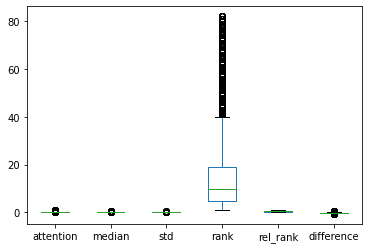

In [13]:
attentions.plot.box()

In [14]:
new_df = attentions[attentions.difference > 0.1].lemma.value_counts().reset_index()
new_df.columns = ["Lemma", "Frequency"]

new_df["RelFreq"] = new_df.Frequency
new_df["RealRelFreq"] = new_df.Frequency

def relfreq(row):
    row.RelFreq = row.Frequency / occurences[row.Lemma]
    return row


def realrelfreq(row):
    row.RealRelFreq = row.Frequency / all_occurences[row.Lemma]
    return row


new_df = new_df.apply(relfreq, axis=1)
new_df = new_df.apply(realrelfreq, axis=1)

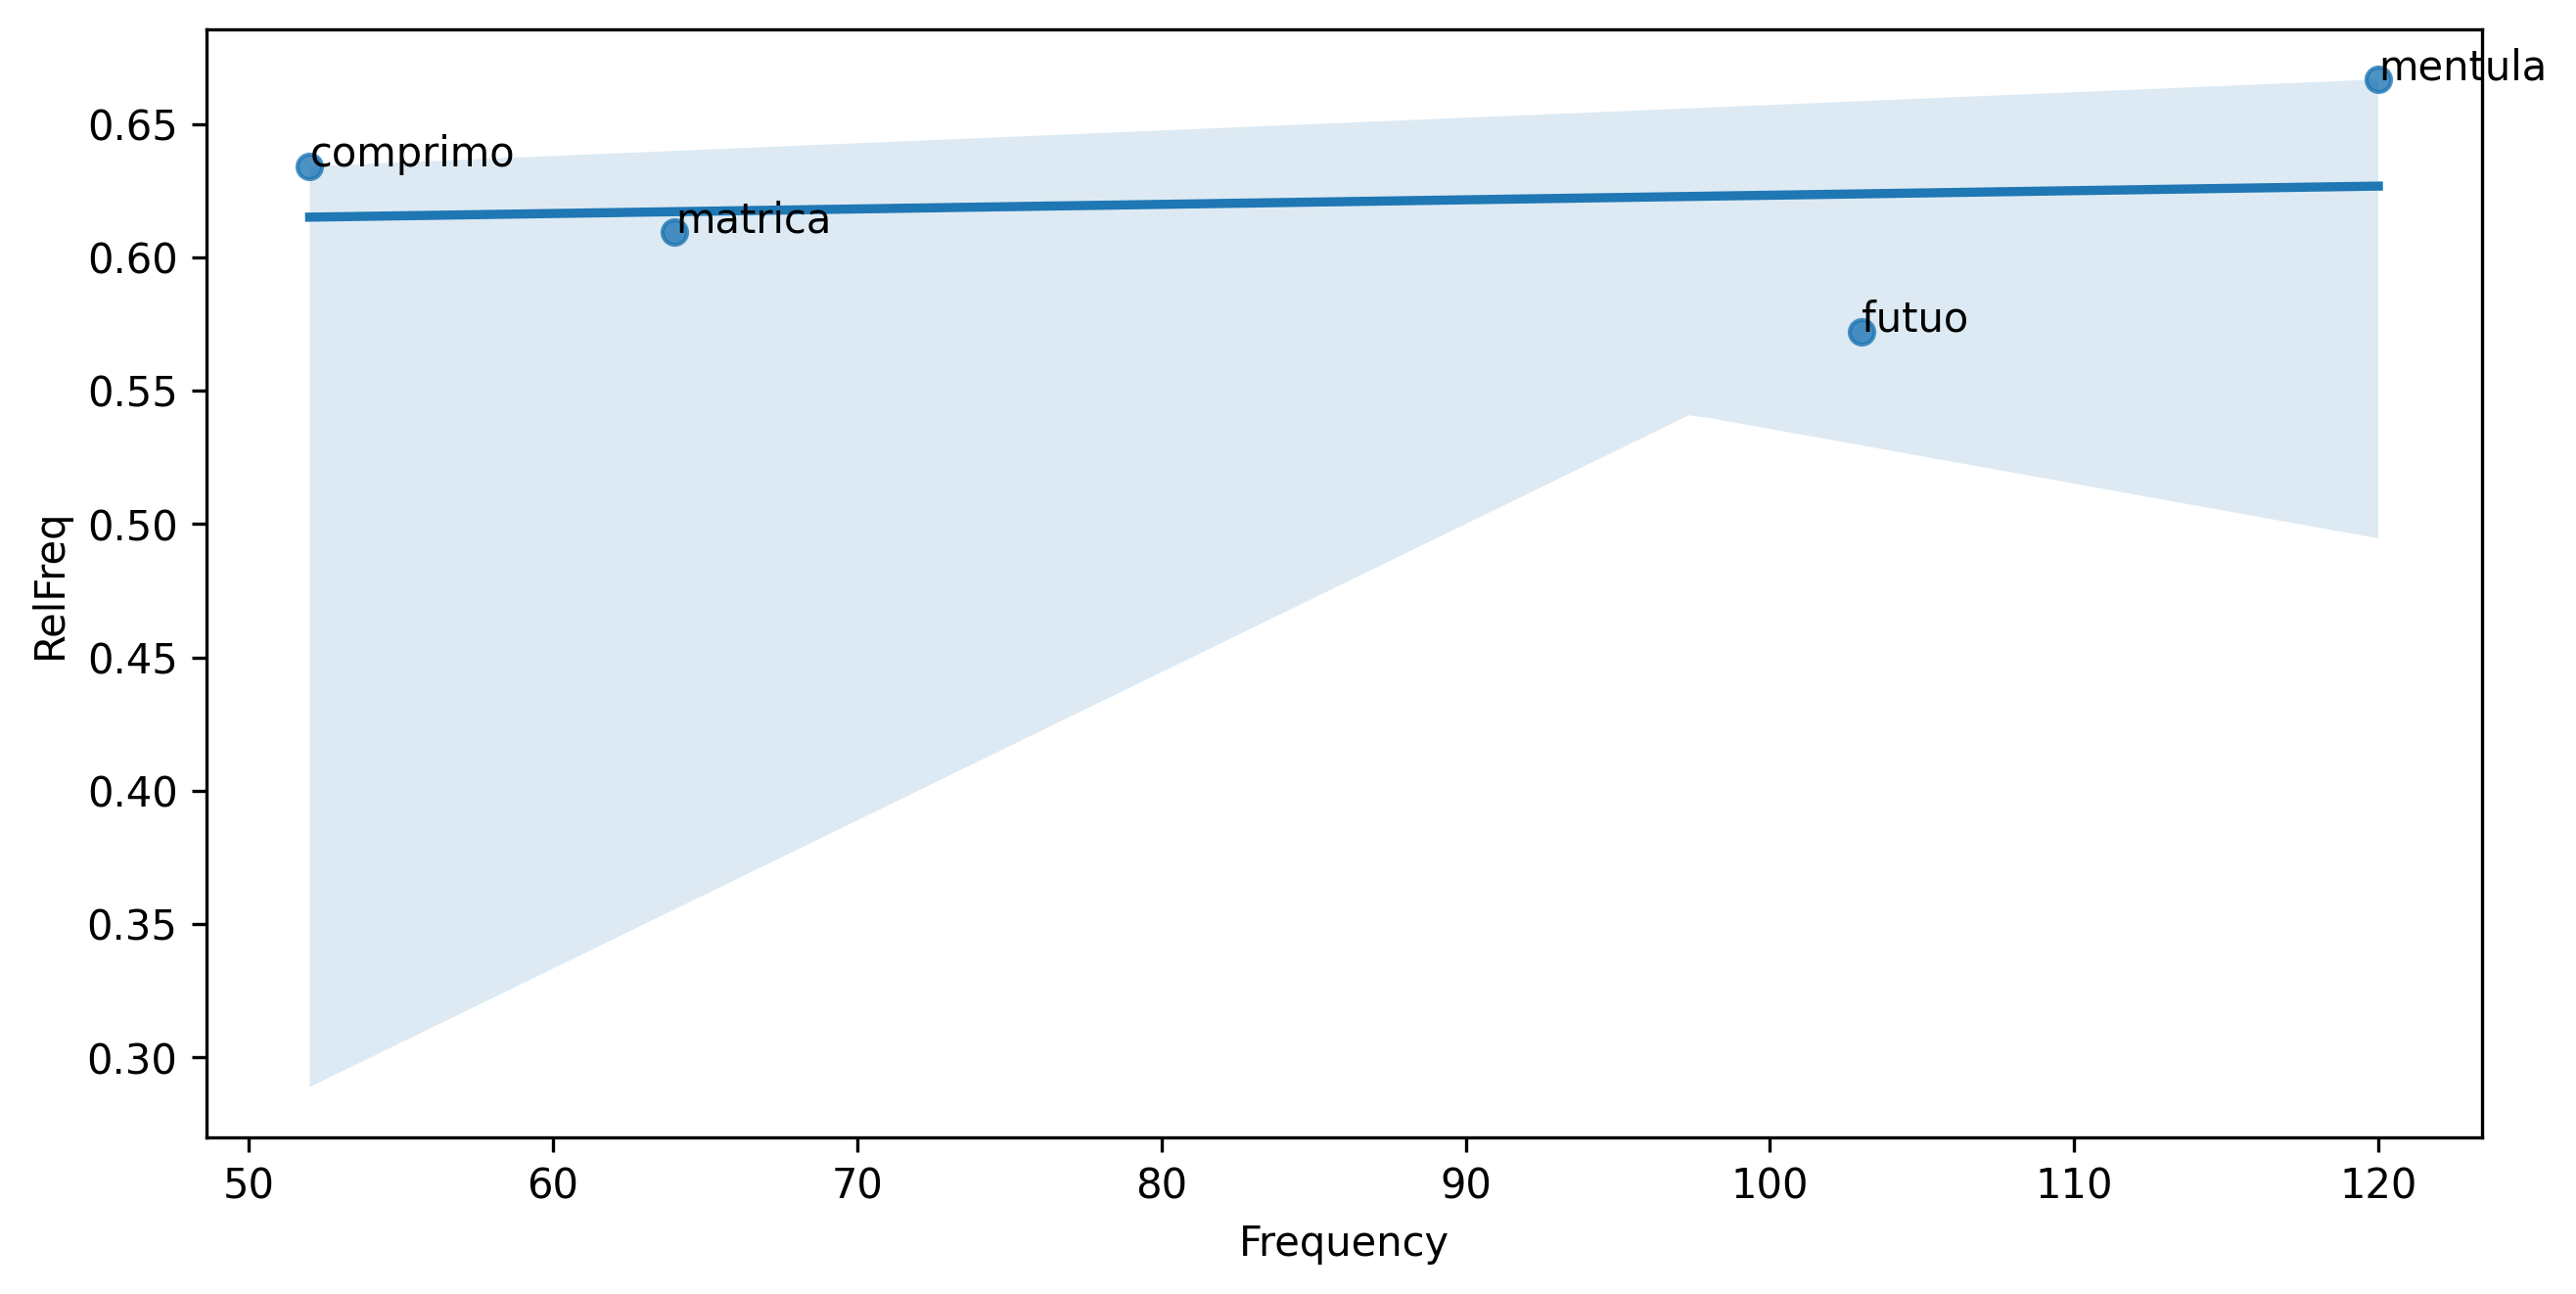

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

filtered_df = new_df.copy()


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))
        
def plot_with_title(df, filtr, y="RelFreq", x="Frequency", **figurekwargs):
    figurekwargs.update(dict(dpi=300, figsize=(10,5)))
    
    fig = plt.figure(**figurekwargs)
    ax = fig.gca()

    ax = sns.regplot(
        x=x, # Horizontal axis
        y=y, # Vertical axis
        data=df[filtr], # Data source
        fit_reg=True, # Don't fix a regression line
        ax=ax)

    label_point(df[filtr][x], df[filtr][y], df[filtr].Lemma, ax=ax)
    
filtr = (filtered_df.Frequency > 50) & (filtered_df.RelFreq > .5)
plot_with_title(filtered_df, filtr=filtr, y="RelFreq")

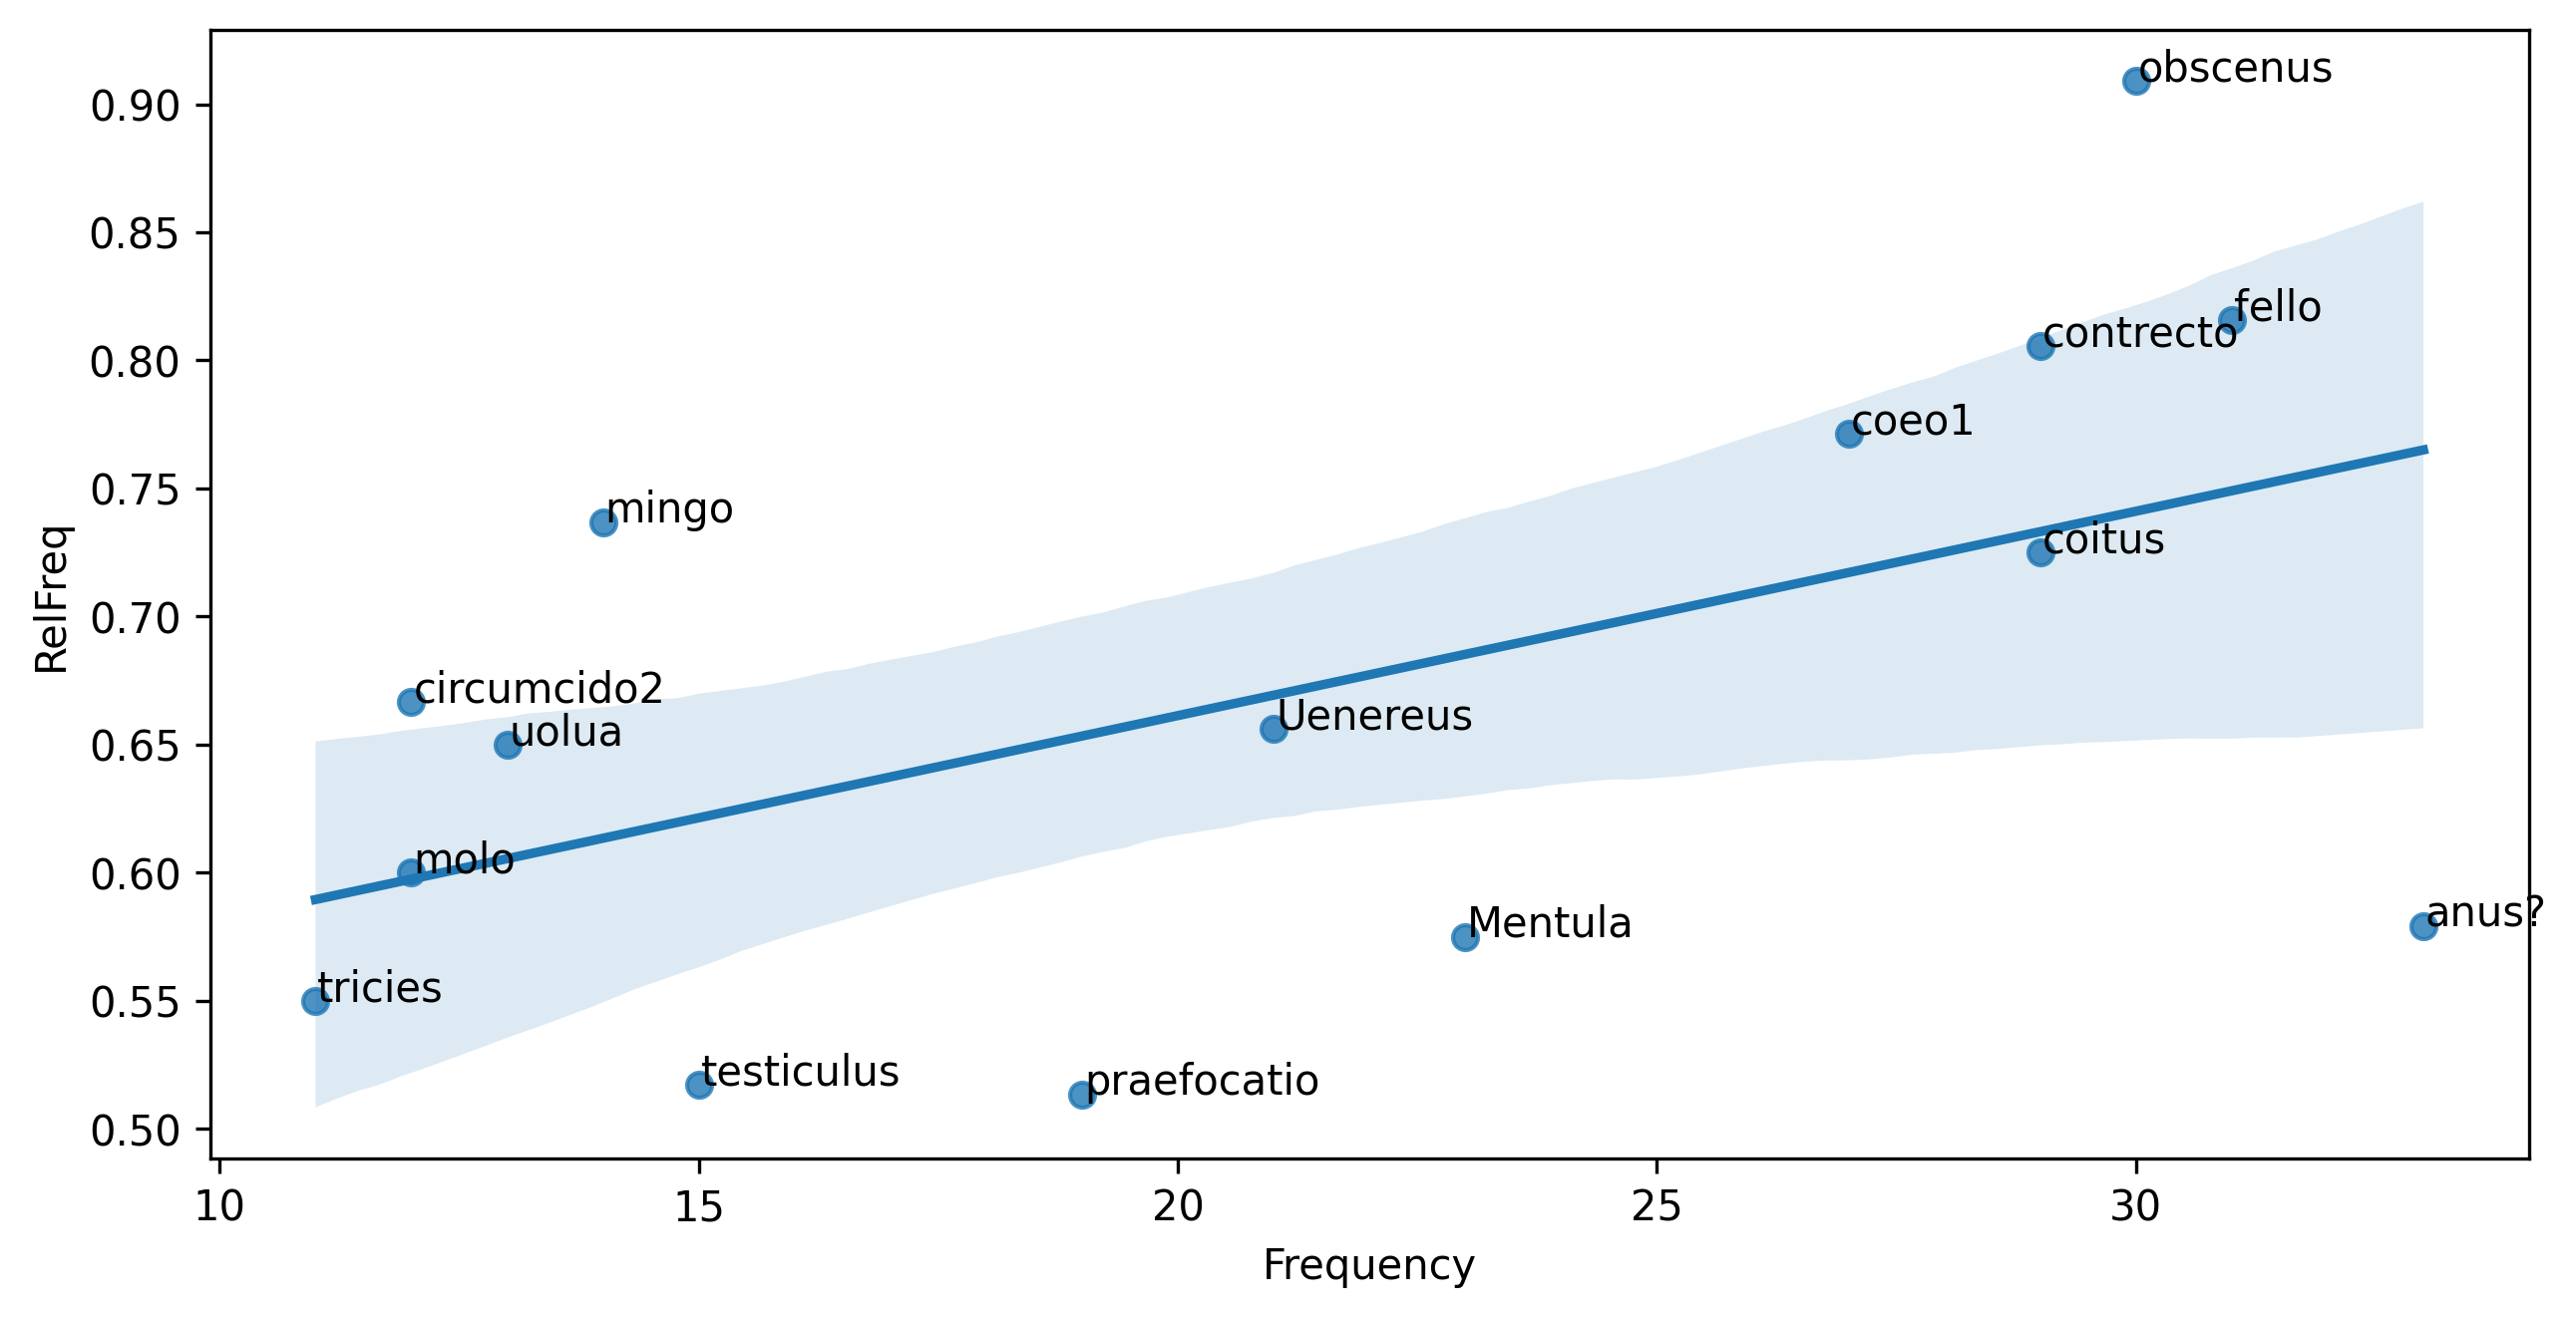

In [16]:
fltr = (filtered_df.Frequency < 50) & (filtered_df.Frequency > 10) & (filtered_df.RelFreq > .5)
plot_with_title(filtered_df, filtr=fltr, y="RelFreq")

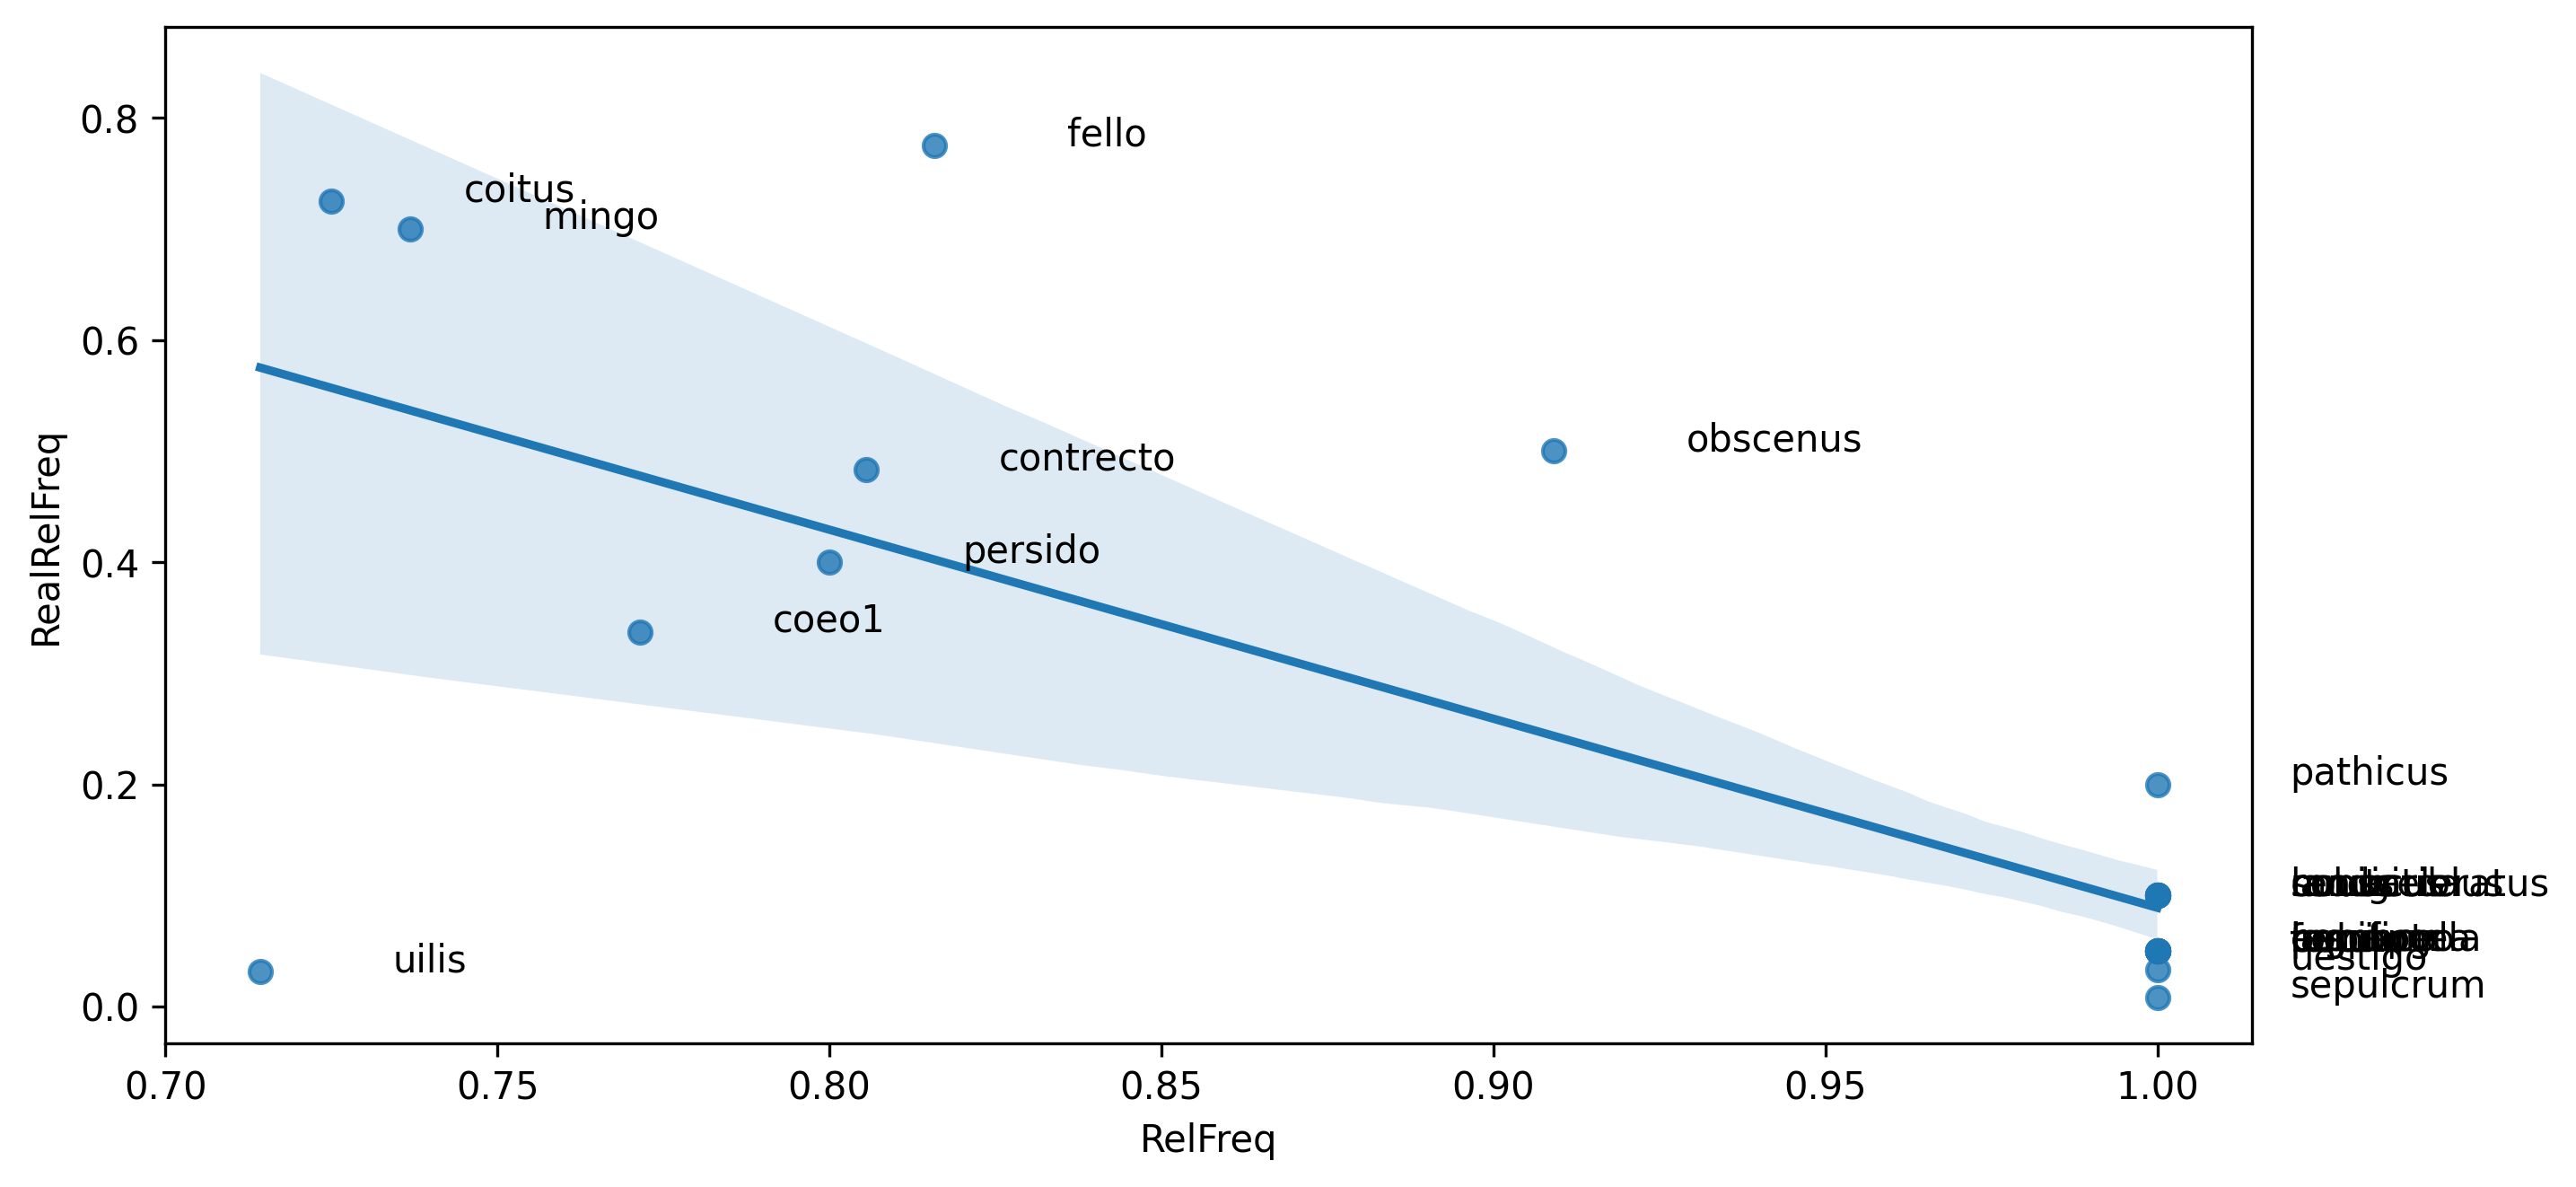

In [17]:
fltr = (filtered_df.RelFreq > .7)
plot_with_title(filtered_df, filtr=fltr, y="RealRelFreq", x="RelFreq")

In [18]:
beautiful_df = filtered_df.copy()[(filtered_df.RelFreq > .5) & (filtered_df.Frequency > 5)]
beautiful_df.columns = [
    "Lemme",
    "Occ(Quantile 0.65)",
    "Occ(.65) / Fréquence(Taggés positifs)",
    "Occ(.65) / Fréquence(Tous les échantillons)"
]
["Lemme"] + list(beautiful_df.columns)[-2:]
print(beautiful_df[["Lemme"] + list(beautiful_df.columns)[-2:]].to_latex(float_format=lambda x: f"{x:.2f}"))


\begin{tabular}{llrr}
\toprule
{} &        Lemme &  Occ(.65) / Fréquence(Taggés positifs) &  Occ(.65) / Fréquence(Tous les échantillons) \\
\midrule
1  &      mentula &                                   0.67 &                                         0.67 \\
2  &        futuo &                                   0.57 &                                         0.57 \\
6  &      matrica &                                   0.61 &                                         0.46 \\
8  &     comprimo &                                   0.63 &                                         0.33 \\
12 &        anus? &                                   0.58 &                                         0.55 \\
14 &        fello &                                   0.82 &                                         0.78 \\
15 &     obscenus &                                   0.91 &                                         0.50 \\
16 &       coitus &                                   0.72 &                            

0.15681207342759557
\begin{tabular}{llrr}
\toprule
{} &          lemme &  occurences &      attn \\
\midrule
72  &          sarus &           0 &  0.221155 \\
91  &          mingo &           0 &  0.240170 \\
90  &     alterutris &           0 &  0.240084 \\
89  &        moechor &           0 &  0.237461 \\
88  &          renus &           0 &  0.236074 \\
87  &        uehetus &           0 &  0.233636 \\
86  &       respergo &           0 &  0.232854 \\
85  &        uereter &           0 &  0.232280 \\
84  &       amiculum &           0 &  0.230132 \\
81  &        molitor &           0 &  0.226449 \\
76  &        caltula &           0 &  0.223298 \\
74  &        demitto &           0 &  0.222408 \\
144 &    mortariolus &           0 &  0.563690 \\
71  &      intorqueo &           0 &  0.215077 \\
70  &        iugulum &           0 &  0.213900 \\
63  &         fuluia &           0 &  0.203644 \\
57  &        tricies &           0 &  0.200513 \\
54  &          uolua &           0 &  0.1

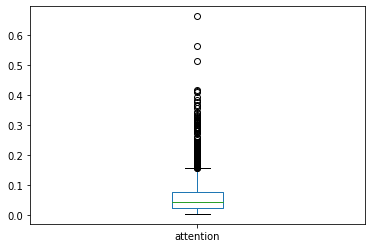

In [19]:
grouped = attentions.groupby("lemma").attention.mean().reset_index()
grouped.plot.box()

q3 = grouped.attention.quantile(.75)
q1 = grouped.attention.quantile(.25)

outliers = q3+1.5*(q3-q1)
print(outliers)

most_common = list(grouped[grouped.attention > outliers].sort_values("attention").lemma.unique())

# Calculer le pourcentage des lemmes dont l'attention est > .quartil ou un truc 
# du genre qui est un des termes annotés !

# Calculer le nombre de rank 1 aussi ? Calculer majorité de rank 1?
print(pd.DataFrame([
    {
        "lemme": lemme,
        "occurences": int(all_occurences[lemme]/models),
        "attn":grouped[grouped.lemma==lemme].attention.tolist()[0]
    }
    for lemme in most_common
]).sort_values("occurences").to_latex())

# Connexion entre Attention et Analyse d'Adams

<AxesSubplot:>

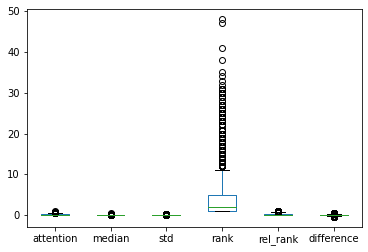

In [20]:
AdamsDf = attentions.copy()
AdamsDf["AdamsRank1"] = False
AdamsDf["Adams"] = False

def adams(row):
    row.Adams = row.lemma in analysis[row.source]
    row.AdamsRank1 = row["rank"] == 1 and row.Adams
    return row


AdamsDf = AdamsDf.apply(adams, axis=1)
AdamsDf[AdamsDf.Adams == True].plot.box("rank")

,attention,median,std,rank,rel_rank,difference
count,4199.000000,4199.000000,4199.000000,4199.000000,4199.000000,4199.000000
mean,0.177639,0.061507,0.063967,4.054299,0.174435,0.052165
std,0.149224,0.057626,0.047727,4.992219,0.237798,0.118351
min,0.001374,0.001765,0.009048,1.000000,0.000000,-0.425011
25%,0.069339,0.023892,0.032091,1.000000,0.000000,-0.025034
50%,0.134922,0.045551,0.050275,2.000000,0.060606,0.031758
75%,0.238700,0.079059,0.081429,5.000000,0.277778,0.111109
max,0.926965,0.454362,0.419858,48.000000,0.966667,0.573596


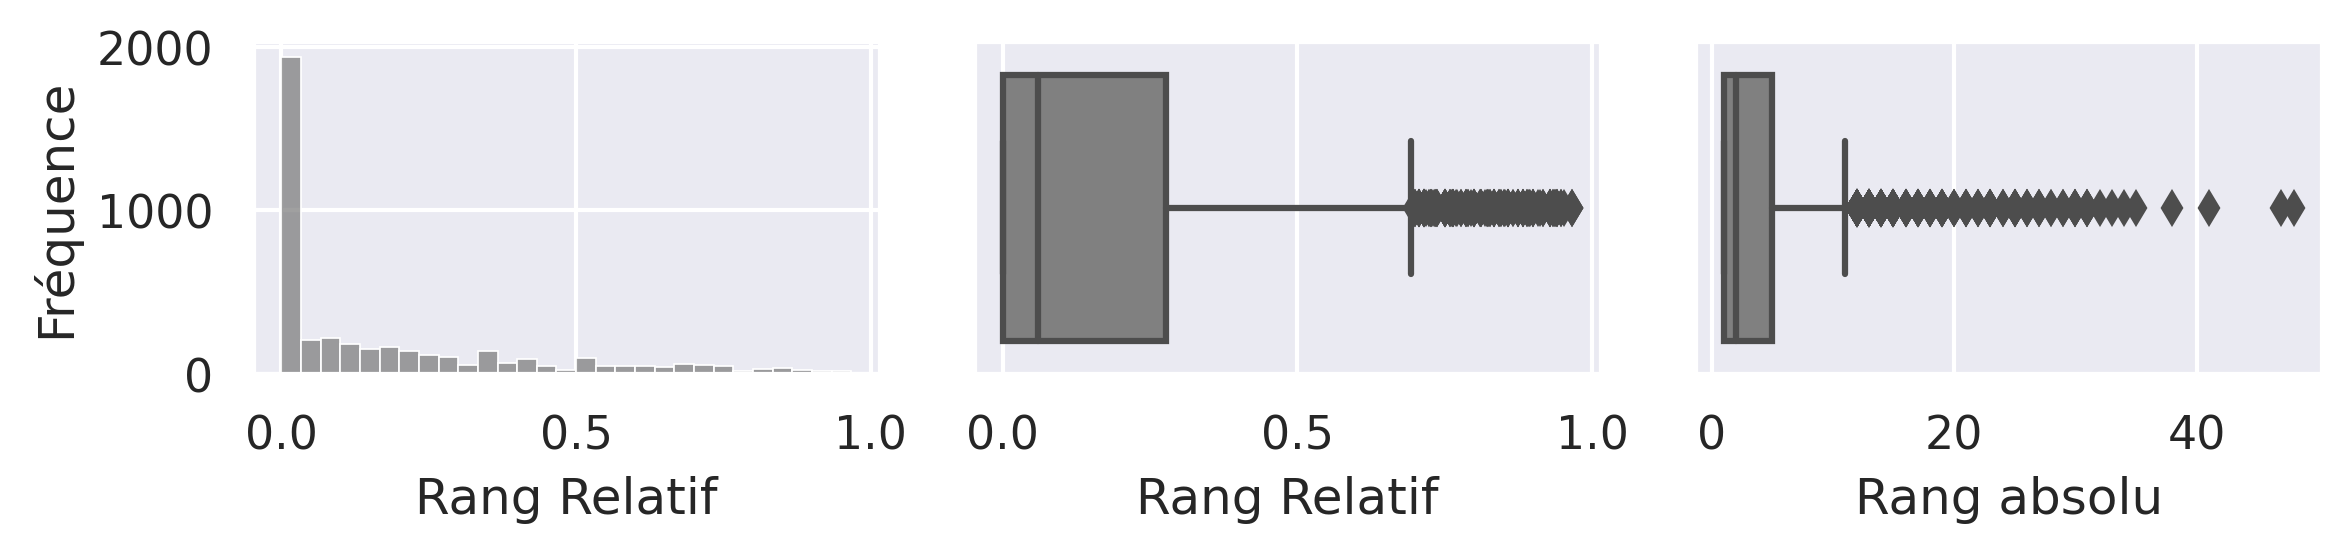

In [21]:
flt = AdamsDf[AdamsDf.Adams == True]


sns.set_theme()
figure, (ax1, ax3, ax2) = plt.subplots(1, 3, dpi=300, figsize=(8,2), tight_layout=True)
sns.histplot(data=flt, x="rel_rank", ax=ax1, color="gray")
ax1.set_xlabel("Rang Relatif")
ax1.set_ylabel("Fréquence")


sns.boxplot(data=flt, x="rank", ax=ax2, color="gray")
ax2.set_ylabel("")
ax2.set_xlabel("Rang absolu")

sns.boxplot(data=flt, x="rel_rank", ax=ax3, color="gray")
#ax2.set_yticklabels(ax.get_yticks(), rotation = 90)
ax3.set_ylabel("")
ax3.set_xlabel("Rang Relatif")

flt.describe()

## Ranks éloignés et phrases

In [22]:
#High ranks ?
# Probleme du rang / lemme: si le lemme est plusieurs fois dans la phrase par exemple
low_ranks = flt[flt["rank"]> 20].copy()

done = []
for idx, row in low_ranks.iterrows():
    #print(row.Lemme, row.Fréquence)
    #print(row.Lemme)
    if row.source in done:
        continue
    done.append(row.source)
    xml = ET.parse(row.source)
    urn = str(xml.xpath("//idno[@type='CTS_URN']/text()")[0])
    #rint(urn)
    display(HTML(str(transform(
        xml,
        lemma=f"'{row.lemma}'",
        frequence=f"'{row['rank']}'",
        nom=f"\"{names.get(urn, 'Inconnu')}\"",
        siecle=f"'{int(is_nan(dates.get(urn, -999)))}'".replace("-999", "Erreur"),
    ))))
    print("====================\n")

# Connexion entre Attention et Faux Positifs

## Navigation dans les faux positifs

In [23]:
rank1_false_positives = attentions[
    (attentions.ok == False) & (attentions.prediction == "positive") & (attentions["rank"] == 1)
].lemma.value_counts().reset_index()


rank1_false_positives.columns = ["Lemme", "Fréquence en rang 1"]
rank1_false_positives["Connu comme positif"] = False

def is_known(row):
    row["Connu comme positif"] = row.Lemme in ALL_ANALYSIS
    return row
    
rank1_false_positives = rank1_false_positives.apply(is_known, axis=1)


rank1_FP_allFreqs = rank1_false_positives["Fréquence en rang 1"].sum()
print(rank1_FP_allFreqs)
rank1_FP_allFreqs_knowns = rank1_false_positives[
    rank1_false_positives["Connu comme positif"] == True
]["Fréquence en rang 1"].sum()
print(rank1_FP_allFreqs_knowns / rank1_FP_allFreqs)

fp_connus = sorted(list(rank1_false_positives[
        rank1_false_positives["Connu comme positif"] == True
    ].Lemme.unique()))

print(fp_connus)

print(
    rank1_false_positives[
        (rank1_false_positives["Connu comme positif"] == False) & \
        (rank1_false_positives["Fréquence en rang 1"] > 1)
    ].to_markdown()
)

fp_interessants = ["amor", "masculus", "femineus", "caltula", "fullo", "lumbus", "concubitus", "uerecundus", "mensturo", 
                   "puella", "pudicus", "mulier", "nox"] + fp_connus

677
0.2895125553914328
['Uenus', 'coitus', 'comprimo', 'corrumpo', 'cum2', 'cum3', 'genitalis', 'gremium', 'iaceo', 'inguen', 'iniuria', 'libido', 'ludo', 'matricus', 'medius', 'misceo', 'muliebris', 'obscenus', 'pes', 'sinus', 'uoluto', 'usus', 'uterus', 'uulua']
|     | Lemme         |   Fréquence en rang 1 | Connu comme positif   |
|----:|:--------------|----------------------:|:----------------------|
|   2 | amor          |                    19 | False                 |
|   8 | ferocitas     |                    14 | False                 |
|   9 | caltula       |                    13 | False                 |
|  11 | fullo         |                    10 | False                 |
|  12 | delibuo       |                    10 | False                 |
|  13 | .             |                     9 | False                 |
|  14 | confleo       |                     9 | False                 |
|  15 | inquino       |                     9 | False                 |
|  16 | menstru

## Mécanisme de récupération des dates

## Récupération des textes avec des faux positifs intéressants

In [24]:
fp_texts = attentions[
    (attentions["rank"] == 1) & \
    (attentions.lemma.isin(fp_interessants)) & \
    (attentions.prediction == "positive") & \
    (attentions.ok == False) 
][["lemma", "attention", "source"]]

fp_texts_counted = fp_texts.value_counts(["lemma", "source"]).reset_index()
fp_texts_counted.columns = ["Lemme", "Source", "Fréquence"]
fp_texts_counted["Century"] = 0

fp_texts_counted = fp_texts_counted.apply(get_date, axis=1)

### Affichage HTML

In [25]:
from IPython.core.display import display, HTML
import math

def is_nan(d):
    if isinstance(d, float) and not math.isnan(d):
        return int(d)
    return -999

for idx, row in fp_texts_counted.iterrows():
    #print(row.Lemme, row.Fréquence)
    #print(row.Lemme)
    display(HTML(str(transform(
        ET.parse(row.Source),
        lemma=f"'{row.Lemme}'",
        frequence=f"'{row.Fréquence/models*100:.2f}%'",
        nom=f"'{names[get_urn(row.Source)]}'",
        siecle=f"'{int(is_nan(dates[get_urn(row.Source)]))}'".replace("-999", "Erreur"),
    ))))
    print("====================\n")

Text(0, 0.5, "Nombre de faux positifs\nà termes 'ambigus'")

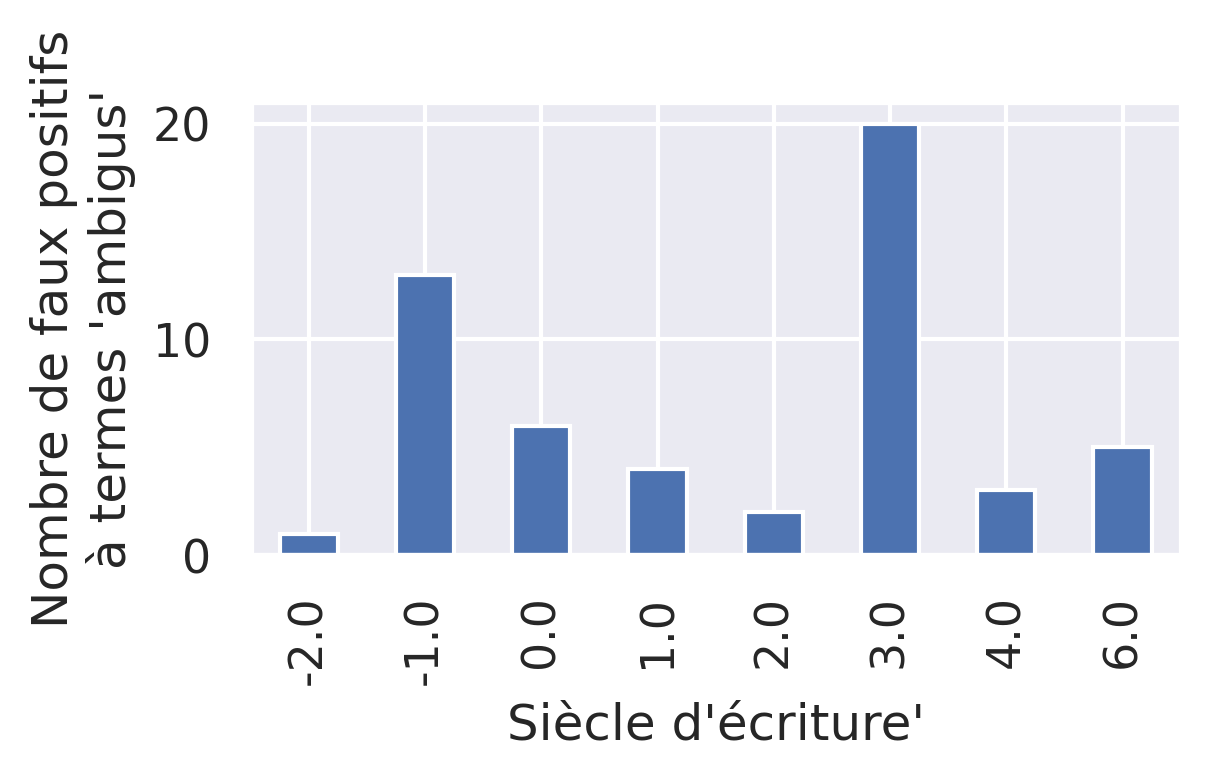

In [26]:
fig = plt.figure(dpi=300, figsize=(4,2))
ax = fig.gca()
fp_texts_counted.Century.value_counts().reset_index().sort_values("index").plot.bar(x="index", ax=ax)
ax.get_legend().remove()
ax.set_xlabel("Siècle d'écriture'")
ax.set_ylabel("Nombre de faux positifs\nà termes 'ambigus'")

## Période de tous les faux positifs

Text(0, 0.5, "Nombre de faux positifs\nà termes 'ambigus'")

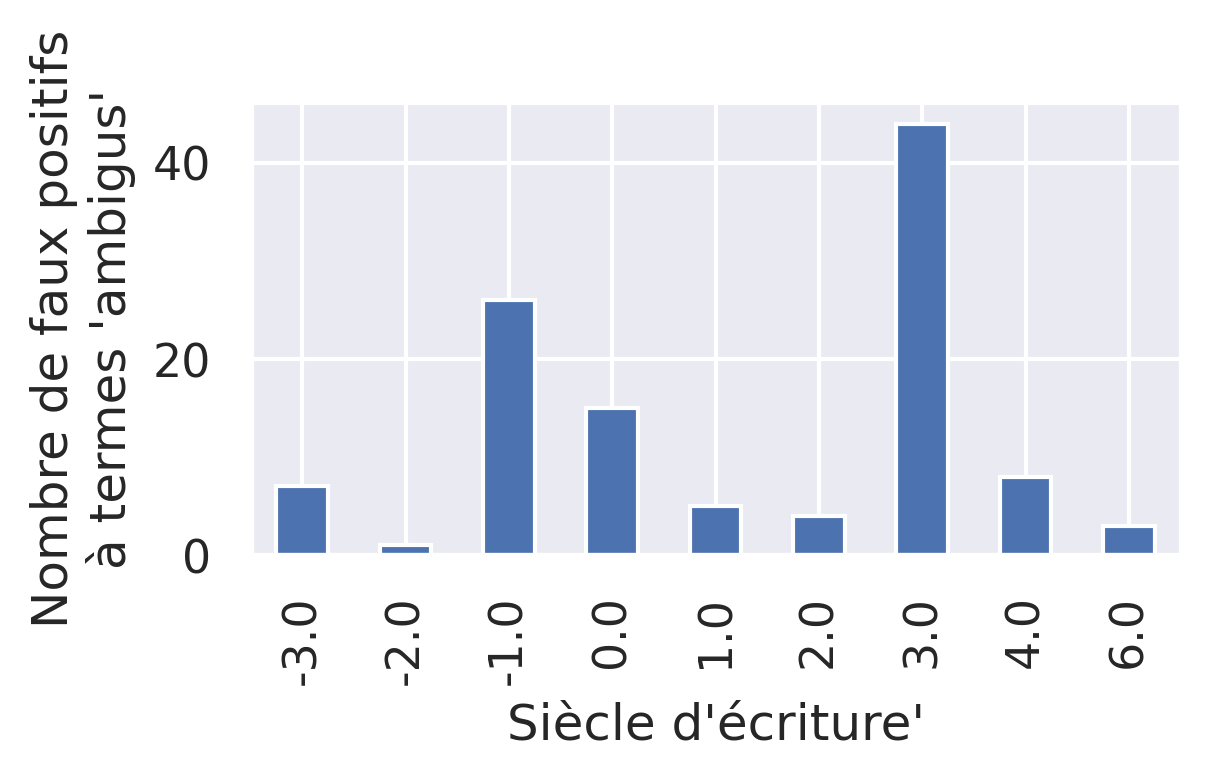

In [27]:
all_fps = attentions[
    (attentions["rank"] == 1) & \
    (attentions.prediction == "positive") & \
    (attentions.ok == False) 
][["source"]]

all_fps_source = all_fps.value_counts(["source"]).reset_index()
all_fps_source.columns = ["Source", "Fréquence"]
all_fps_source["Century"] = 0
all_fps_source["Nom"] = ""

all_fps_source = all_fps_source.apply(get_date, axis=1)
all_fps_source = all_fps_source.apply(get_nom, axis=1)


fig = plt.figure(dpi=300, figsize=(4,2))
ax = fig.gca()
all_fps_source.Century.value_counts().reset_index().sort_values("index").plot.bar(x="index", ax=ax)
ax.get_legend().remove()
ax.set_xlabel("Siècle d'écriture'")
ax.set_ylabel("Nombre de faux positifs\nà termes 'ambigus'")


In [28]:
all_fps["Nom"] = ""

def get_nom_wrapped(row):
    return get_nom(row, "source")

all_fps = all_fps.apply(get_nom_wrapped, axis=1)

all_authors = all_fps.value_counts(["Nom"]).reset_index()
all_authors.columns = ["Nom", "Fréquence"]
all_authors[all_authors.Fréquence > 5]

,Nom,Fréquence
0,Vulgate,83
1,Ovide,77
2,Augustin,42
3,Vindicianus,40
4,Apulée,33
5,Plaute,32
6,Priapées,29
7,Caelius Aurelianus,20
8,"Firmicus Maternus, Julius",20
9,Eucher de Lyon,20


# Faux négatifs

In [44]:
occurences = Counter()
all_occurences = Counter()
analysis = defaultdict(list)
sents = defaultdict(list)
occs_per_cat = defaultdict(Counter)

for file in tqdm.tqdm(glob.glob(PATH)):
    if "Enriched" in file:
        continue
    #print(file)
    df = pandas.read_csv(file)
    # print(data.head)
    df["attention"] = df["attention"].apply(lambda x: np.array(eval(x)))
    df["ok"] = df["prediction"] == df["label"]

    for i, row in df.iterrows():
        xml = ET.parse(row.fp)
        
        if not sents[row.fp]:
            sents[row.fp] = list(map(str, xml.xpath("//w/@lemma")))
            
        lemmas = sents[row.fp]
        
        if "these-corpus" in row.fp and not analysis[row.fp]:
            analysis[row.fp] = list(map(str, xml.xpath("//w[@ana]/@lemma")))
            
        row.attention = row.attention[:len(lemmas)]
        occurences += Counter(lemmas)
        all_occurences  += Counter(lemmas)
        occs_per_cat[row.label] += Counter(lemmas)
        med = np.median(row.attention)
        std = row.attention.std()
        quantile = np.quantile(row.attention, 0.74)
        
        ranks = (
            1 + len(lemmas) - (row.attention.argsort().argsort()+1)
        )
        
        words = sorted([
            Data(w, l, a, med, std, row.ok, row.prediction, row.fp, file, rank, (rank-1)/len(lemmas), 
                 simple_status(row.ok, row.prediction), row["score-prediction"], row.attention)
            for w, a, l, rank in zip(row.sentence.split(), row.attention, lemmas, ranks)
        ], reverse=True, key=lambda x: x[2])

        for w in words:
            tops.append(w)
            
#    for i, row in df[df.prediction == "positive"].iterrows():
#        xml = ET.parse(row.fp)
#        if not sents[row.fp]:
#            sents[row.fp] = list(map(str, xml.xpath("//w/@lemma")))
#        lemmas = sents[row.fp]
#        all_occurences += Counter(lemmas)
#        occs_per_cat[row.label] += Counter(lemmas)


100%|███████████████████████████████████████████| 40/40 [01:15<00:00,  1.88s/it]


Counter({'manus1': 200,
         'percutio': 40,
         'crudelis': 20,
         'mors': 100,
         'punio': 20,
         'sum1': 1940,
         ':': 920,
         'quis1': 180,
         'de': 140,
         'tu': 780,
         'arbitror': 20,
         ',': 7760,
         'perdite': 20,
         'pariter': 40,
         'et2': 2120,
         'perditor': 20,
         'qui1': 1620,
         'uas2': 20,
         'rationabilis': 20,
         'consecro': 20,
         'Christus': 20,
         'sanctifico': 20,
         'spiritus': 20,
         'sanctus': 20,
         'impie': 20,
         'temero': 20,
         'polluo': 20,
         'sacrilege': 20,
         'tuus': 220,
         'propositum': 20,
         'immemor': 40,
         'iudicium': 20,
         'diuinus2': 20,
         'contemplor': 20,
         '?': 440,
         'ille': 480,
         'uxor': 260,
         'aut': 260,
         'amica': 80,
         'riualis1': 20,
         'lasciuio': 20,
         'languidus': 60,
         'pr

In [47]:
attentions = pandas.DataFrame(tops, columns=Cols).sort_values(
    "attention", ascending=False
)
attentions["Statut"] = attentions.status
#attentions = attentions.apply(get_status, axis=1)

In [7]:
attentions[(attentions.prediction=="negative") & (attentions.ok == False)]

,word,lemma,attention,median,std,ok,prediction,source,model,rank,rel_rank,status,Statut
705951,veneriae,Uenereus,0.687150,0.046382,0.223201,False,negative,/home/thibault/dev/these-corpus/data/1194.xml,test_dumps/main.AggloMSD-HAN-None-Word2Vec-256...,1,0.000000,Faux négatif,Faux négatif
76398,matrix,matrix,0.617180,0.012690,0.112024,False,negative,/home/thibault/dev/these-corpus/data/841.xml,test_dumps/main.AggloMSD-HAN-None-Word2Vec-128...,1,0.000000,Faux négatif,Faux négatif
671390,compressisse,comprimo,0.599621,0.047106,0.167433,False,negative,/home/thibault/dev/these-corpus/data/1716.xml,test_dumps/main.AggloMSD-HAN-None-Word2Vec-256...,1,0.000000,Faux négatif,Faux négatif
993096,veneriae,Uenereus,0.593828,0.075632,0.184464,False,negative,/home/thibault/dev/these-corpus/data/1194.xml,test_dumps/main.AggloMSD-HAN-None-Word2Vec-128...,1,0.000000,Faux négatif,Faux négatif
285508,pathicae,pathicus,0.582415,0.071238,0.180147,False,negative,/home/thibault/dev/these-corpus/data/1915.xml,test_dumps/main.AggloMSD-HAN-None-Word2Vec-128...,1,0.000000,Faux négatif,Faux négatif
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188827,etiam,etiam,0.002582,0.006442,0.029082,False,negative,/home/thibault/dev/these-corpus/data/90.xml,test_dumps/main.AggloMSD-HAN-None-Word2Vec-256...,54,0.946429,Faux négatif,Faux négatif
188828,quibusdam,quidam,0.002556,0.006442,0.029082,False,negative,/home/thibault/dev/these-corpus/data/90.xml,test_dumps/main.AggloMSD-HAN-None-Word2Vec-256...,55,0.964286,Faux négatif,Faux négatif
654177,tertio,tertius,0.002471,0.007484,0.069686,False,negative,/home/thibault/dev/these-corpus/data/1857.xml,test_dumps/main.AggloMSD-HAN-None-Word2Vec-256...,39,0.974359,Faux négatif,Faux négatif
188829,",",",",0.002365,0.006442,0.029082,False,negative,/home/thibault/dev/these-corpus/data/90.xml,test_dumps/main.AggloMSD-HAN-None-Word2Vec-256...,56,0.982143,Faux négatif,Faux négatif


<AxesSubplot:>

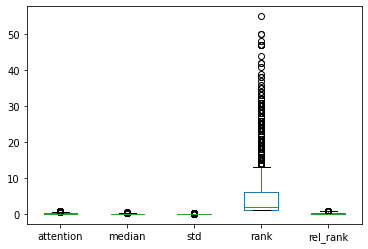

In [8]:
AdamsDf = attentions.copy()
AdamsDf["AdamsRank1"] = False
AdamsDf["Adams"] = False

def adams(row):
    row.Adams = row.lemma in analysis[row.source]
    row.AdamsRank1 = row["rank"] == 1 and row.Adams
    return row


AdamsDf = AdamsDf.apply(adams, axis=1)
AdamsDf[AdamsDf.Adams == True].plot.box("rank")

In [9]:
flt = AdamsDf[(AdamsDf.Adams == True)].copy()
flt = flt.apply(get_status, axis=1)

In [35]:
#AdamsDf[(AdamsDf.prediction=="negative") & (AdamsDf.ok == False) & (AdamsDf.Adams == True)]


,attention,median,std,rank,rel_rank
count,6040.000000,6040.000000,6040.000000,6040.000000,6040.000000
mean,0.157825,0.061988,0.056564,4.770861,0.210259
std,0.138125,0.053642,0.043916,5.770646,0.257241
min,0.001374,0.001765,0.003472,1.000000,0.000000
25%,0.059414,0.026075,0.027876,1.000000,0.000000
50%,0.117414,0.048077,0.043613,2.000000,0.100000
75%,0.210808,0.079754,0.071734,6.000000,0.352941
max,0.926965,0.454362,0.419858,55.000000,0.970588


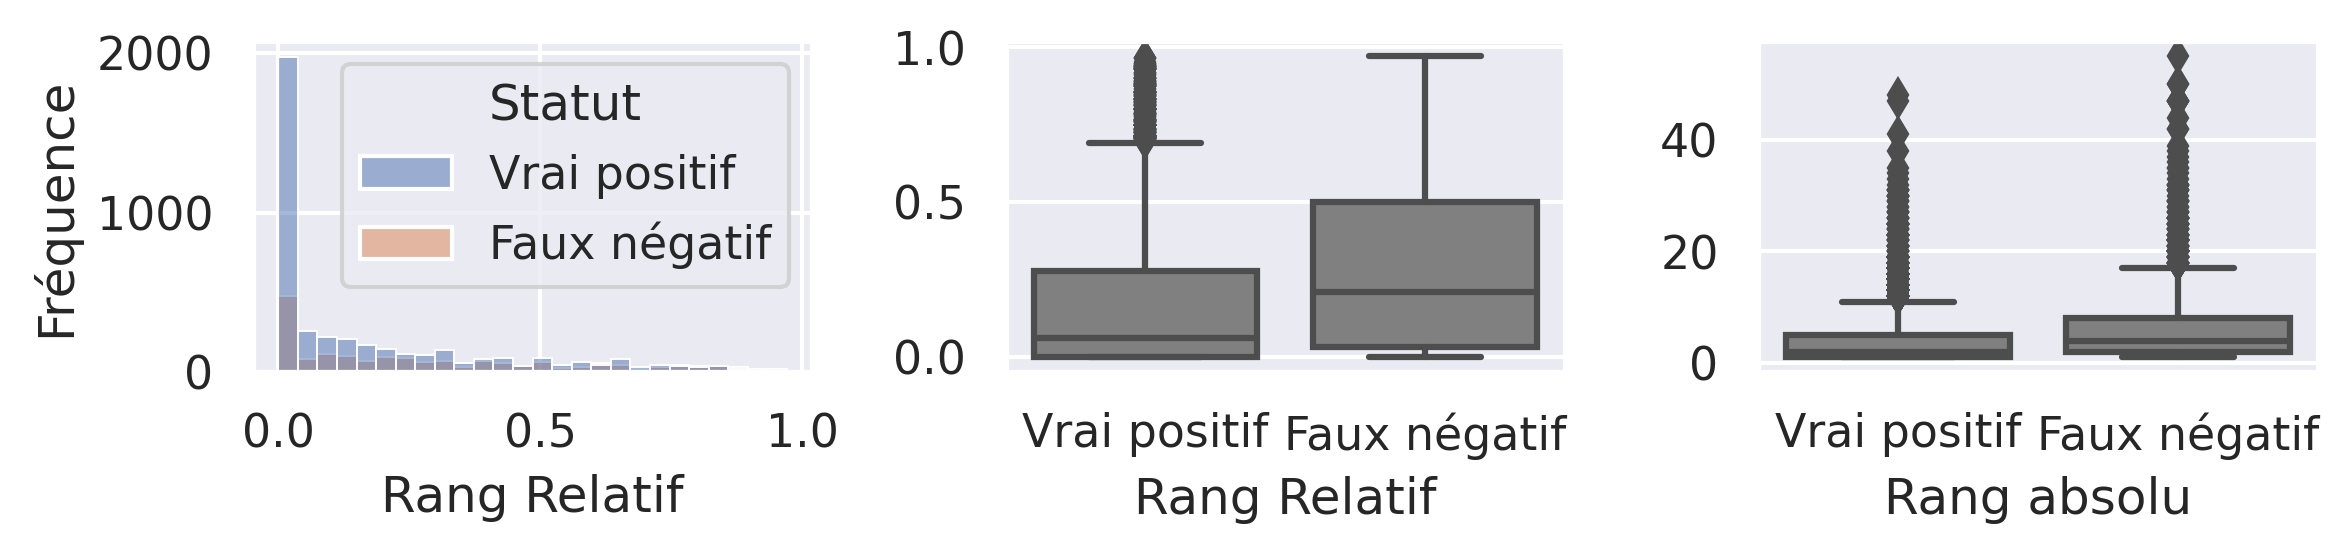

In [10]:
sns.set_theme()
figure, (ax1, ax3, ax2) = plt.subplots(1, 3, dpi=300, figsize=(8,2), tight_layout=True)
sns.histplot(data=flt, x="rel_rank", ax=ax1, hue="Statut", color="gray")
ax1.set_xlabel("Rang Relatif")
ax1.set_ylabel("Fréquence")

# ax1.get_legend().set_title("")
sns.boxplot(data=flt, y="rank", x="Statut", ax=ax2, color="gray")
ax2.set_ylabel("")
ax2.set_xlabel("Rang absolu")

sns.boxplot(data=flt, y="rel_rank", x="Statut", ax=ax3, color="gray")
#ax2.set_yticklabels(ax.get_yticks(), rotation = 90)
ax3.set_ylabel("")
ax3.set_xlabel("Rang Relatif")

flt.describe()

In [11]:
flt.groupby("Statut")["rank"].describe()

,count,mean,std,min,25%,50%,75%,max
Statut,,,,,,,,
Faux négatif,1841.0,6.405215,6.970579,1.0,2.0,4.0,8.0,55.0
Vrai positif,4199.0,4.054299,4.992219,1.0,1.0,2.0,5.0,48.0


In [12]:
x = attentions[
    (attentions["lemma"].isin([".", ",", "!", "?", ";"]) == True) & \
    (attentions["rank"] == 1)
].value_counts(["lemma", "Statut"]).reset_index()
x.columns = ["Lemme", "Statut", "Fréquence"]
x = x.sort_values("Fréquence", ascending=False).groupby(["Lemme", "Statut"]).sum().reset_index()#.to_latex(index=False)

def rel_freq(row):
    status = "positive" if (row.Statut != "Faux positif" and row.Statut != "Vrai négatif") else "negative"
    row["Fréquence relative"] = row.Fréquence / occs_per_cat[status][row.Lemme] * 100
    return row
    
x = x.apply(rel_freq, axis=1)
print(
    x.sort_values(["Lemme"]).pivot_table(values="Fréquence relative", index="Lemme", columns="Statut").fillna("").to_latex(float_format=lambda x: f"{x:.2f}")
)

\begin{tabular}{lrlrl}
\toprule
Statut &  Faux négatif & Faux positif &  Vrai négatif & Vrai positif \\
Lemme &               &              &               &              \\
\midrule
!     &         33.33 &         0.13 &         26.97 &              \\
,     &          0.01 &         0.00 &          0.11 &         0.06 \\
.     &          5.72 &         0.02 &         35.63 &         1.50 \\
;     &          3.38 &              &         22.28 &              \\
?     &          8.18 &              &         48.25 &         0.45 \\
\bottomrule
\end{tabular}



In [13]:
y = attentions[
    (attentions["rank"] == 1)
].value_counts(["lemma", "Statut"]).reset_index()
y.columns = ["Lemme", "Statut", "Fréquence"]
y[(y.Fréquence > 10) & (y.Statut == "Faux négatif")]


,Lemme,Statut,Fréquence
12,.,Faux négatif,183
115,libido,Faux négatif,45
148,?,Faux négatif,36
201,corrumpo,Faux négatif,27
205,genitalis,Faux négatif,27
229,matrix,Faux négatif,25
239,;,Faux négatif,25
266,matrica,Faux négatif,22
291,!,Faux négatif,20
292,puella,Faux négatif,20


In [15]:

fp_texts = attentions[
    (attentions["rank"] == 1) & \
    (attentions.Statut == "Faux négatif") 
][["lemma", "attention", "source"]]

fp_texts_counted = fp_texts.value_counts(["lemma", "source"]).reset_index()
fp_texts_counted.columns = ["Lemme", "Source", "Fréquence"]
fp_texts_counted["Century"] = 0

done = []
for idx, row in fp_texts_counted.iterrows():
    #print(row.Lemme, row.Fréquence)
    #print(row.Lemme)
    if row.Source in done:
        continue
    done.append(row.Source)
    xml = ET.parse(row.Source)
    urn = str(xml.xpath("//idno[@type='CTS_URN']/text()")[0])
    #rint(urn)
    print(row.Source)
    display(HTML(str(transform(
        xml,
        lemma=f"'{row.Lemme}'",
        frequence=f"'{row['Fréquence']}'",
        nom=f"\"{names.get(urn, 'Inconnu')}\"",
        siecle=f"'{int(is_nan(dates.get(urn, -999)))}'".replace("-999", "Erreur"),
    ))))
    print("====================\n")

/home/thibault/dev/these-corpus/data/1822.xml



/home/thibault/dev/these-corpus/data/117.xml



/home/thibault/dev/these-corpus/data/1285.xml



/home/thibault/dev/these-corpus/data/2063.xml



/home/thibault/dev/these-corpus/data/1967.xml



/home/thibault/dev/these-corpus/data/1938.xml



/home/thibault/dev/these-corpus/data/2141.xml



/home/thibault/dev/these-corpus/data/2395.xml



/home/thibault/dev/these-corpus/data/1327.xml



/home/thibault/dev/these-corpus/data/2203.xml



/home/thibault/dev/these-corpus/data/1482.xml



/home/thibault/dev/these-corpus/data/841.xml



/home/thibault/dev/these-corpus/data/2114.xml



/home/thibault/dev/these-corpus/data/543.xml



/home/thibault/dev/these-corpus/data/1728.xml



/home/thibault/dev/these-corpus/data/1363.xml



/home/thibault/dev/these-corpus/data/1684.xml



/home/thibault/dev/these-corpus/data/2415.xml



/home/thibault/dev/these-corpus/data/1915.xml



/home/thibault/dev/these-corpus/data/1837.xml



/home/thibault/dev/these-corpus/data/467.xml



/home/thibault/dev/these-corpus/data/1249.xml



/home/thibault/dev/these-corpus/data/1375.xml



/home/thibault/dev/these-corpus/data/1201.xml



/home/thibault/dev/these-corpus/data/1734.xml



/home/thibault/dev/these-corpus/data/2000.xml



/home/thibault/dev/these-corpus/data/492.xml



/home/thibault/dev/these-corpus/data/834.xml



/home/thibault/dev/these-corpus/data/351.xml



/home/thibault/dev/these-corpus/data/1207.xml



/home/thibault/dev/these-corpus/data/2211.xml



/home/thibault/dev/these-corpus/data/1716.xml



/home/thibault/dev/these-corpus/data/2266.xml



/home/thibault/dev/these-corpus/data/1464.xml



/home/thibault/dev/these-corpus/data/858.xml



/home/thibault/dev/these-corpus/data/1992.xml



/home/thibault/dev/these-corpus/data/2439.xml



/home/thibault/dev/these-corpus/data/2217.xml



/home/thibault/dev/these-corpus/data/1217.xml



/home/thibault/dev/these-corpus/data/1216.xml



/home/thibault/dev/these-corpus/data/1445.xml



/home/thibault/dev/these-corpus/data/133.xml



/home/thibault/dev/these-corpus/data/1657.xml



/home/thibault/dev/these-corpus/data/1466.xml



/home/thibault/dev/these-corpus/data/1909.xml



/home/thibault/dev/these-corpus/data/106.xml



/home/thibault/dev/these-corpus/data/1194.xml



/home/thibault/dev/these-corpus/data/2187.xml



/home/thibault/dev/these-corpus/data/1797.xml



/home/thibault/dev/these-corpus/data/1857.xml



/home/thibault/dev/these-corpus/data/1678.xml



/home/thibault/dev/these-corpus/data/2495.xml



/home/thibault/dev/these-corpus/data/447.xml



/home/thibault/dev/these-corpus/data/2020.xml



/home/thibault/dev/these-corpus/data/630.xml



/home/thibault/dev/these-corpus/data/550.xml



/home/thibault/dev/these-corpus/data/1710.xml



/home/thibault/dev/these-corpus/data/1812.xml



/home/thibault/dev/these-corpus/data/1116.xml



/home/thibault/dev/these-corpus/data/237.xml



/home/thibault/dev/these-corpus/data/53.xml



/home/thibault/dev/these-corpus/data/575.xml



/home/thibault/dev/these-corpus/data/1353.xml



/home/thibault/dev/these-corpus/data/1329.xml



/home/thibault/dev/these-corpus/data/409.xml



/home/thibault/dev/these-corpus/data/74.xml



/home/thibault/dev/these-corpus/data/2149.xml



/home/thibault/dev/these-corpus/data/1638.xml



/home/thibault/dev/these-corpus/data/614.xml



/home/thibault/dev/these-corpus/data/134.xml



/home/thibault/dev/these-corpus/data/854.xml



/home/thibault/dev/these-corpus/data/342.xml



/home/thibault/dev/these-corpus/data/1587.xml



/home/thibault/dev/these-corpus/data/289.xml



/home/thibault/dev/these-corpus/data/370.xml



/home/thibault/dev/these-corpus/data/595.xml



/home/thibault/dev/these-corpus/data/52.xml



/home/thibault/dev/these-corpus/data/1432.xml



/home/thibault/dev/these-corpus/data/2073.xml



/home/thibault/dev/these-corpus/data/2067.xml



/home/thibault/dev/these-corpus/data/2480.xml



/home/thibault/dev/these-corpus/data/1362.xml



/home/thibault/dev/these-corpus/data/2026.xml



/home/thibault/dev/these-corpus/data/1786.xml



/home/thibault/dev/these-corpus/data/2403.xml



/home/thibault/dev/these-corpus/data/1098.xml



/home/thibault/dev/these-corpus/data/976.xml



/home/thibault/dev/these-corpus/data/2204.xml



/home/thibault/dev/these-corpus/data/855.xml



/home/thibault/dev/these-corpus/data/229.xml



/home/thibault/dev/these-corpus/data/406.xml



/home/thibault/dev/these-corpus/data/2434.xml



/home/thibault/dev/these-corpus/data/24.xml



/home/thibault/dev/these-corpus/data/2091.xml



/home/thibault/dev/these-corpus/data/2134.xml



/home/thibault/dev/these-corpus/data/1386.xml



/home/thibault/dev/these-corpus/data/853.xml



/home/thibault/dev/these-corpus/data/979.xml



/home/thibault/dev/these-corpus/data/2154.xml



/home/thibault/dev/these-corpus/data/2066.xml



/home/thibault/dev/these-corpus/data/1347.xml



/home/thibault/dev/these-corpus/data/1265.xml



/home/thibault/dev/these-corpus/data/1190.xml



/home/thibault/dev/these-corpus/data/1161.xml



/home/thibault/dev/these-corpus/data/90.xml



/home/thibault/dev/these-corpus/data/168.xml



/home/thibault/dev/these-corpus/data/347.xml



/home/thibault/dev/these-corpus/data/532.xml



/home/thibault/dev/these-corpus/data/297.xml



/home/thibault/dev/these-corpus/data/266.xml



/home/thibault/dev/these-corpus/data/640.xml



/home/thibault/dev/these-corpus/data/1142.xml



/home/thibault/dev/these-corpus/data/1226.xml



/home/thibault/dev/these-corpus/data/1420.xml



/home/thibault/dev/these-corpus/data/2276.xml



/home/thibault/dev/these-corpus/data/730.xml



/home/thibault/dev/these-corpus/data/435.xml



/home/thibault/dev/these-corpus/data/156.xml



/home/thibault/dev/these-corpus/data/2167.xml



/home/thibault/dev/these-corpus/data/226.xml



/home/thibault/dev/these-corpus/data/183.xml



/home/thibault/dev/these-corpus/data/91.xml



/home/thibault/dev/these-corpus/data/1152.xml



/home/thibault/dev/these-corpus/data/2458.xml



/home/thibault/dev/these-corpus/data/594.xml



/home/thibault/dev/these-corpus/data/1211.xml



/home/thibault/dev/these-corpus/data/844.xml



/home/thibault/dev/these-corpus/data/864.xml



/home/thibault/dev/these-corpus/data/2511.xml



/home/thibault/dev/these-corpus/data/984.xml


## Viz attention details

In [57]:
import numpy as np
file = attentions[(attentions.source == "/home/thibault/dev/these-corpus/data/841.xml") & (attentions["rank"] == 1)]
print(file["Statut"].describe())
print(file["score"].describe())


np.average([row for row in file.allAttention], axis=0)

count               20
unique               1
top       Faux négatif
freq                20
Name: Statut, dtype: object
count    20.000000
mean      0.916501
std       0.108125
min       0.537811
25%       0.890343
50%       0.947047
75%       0.990244
max       0.998464
Name: score, dtype: float64


array([0.03149475, 0.03772428, 0.15748645, 0.02793746, 0.04317584,
       0.02646271, 0.02126797, 0.02378313, 0.02285044, 0.02566464,
       0.03361236, 0.02554222, 0.02139504, 0.02485481, 0.02901251,
       0.02030384, 0.03002609, 0.02983539, 0.02895636, 0.02990857,
       0.02925925, 0.03310733, 0.03074769, 0.02566179, 0.04489055,
       0.03752601, 0.0538668 , 0.05354572])

In [63]:
from IPython.core.display import display as _display, HTML  as _HTML
from colour import Color

COLORS = [Color("white")] + list(Color("white").range_to(Color("red"),50))

def visualize(source, attention, tag="p", colors=None, display=True, label=None, is_right: bool = False,
             show_score: bool = False, use_subword=False):
    if not colors:
        colors = COLORS
        
    for idx, row in fp_texts_counted.iterrows():
        xml = ET.parse(source)
        urn = str(xml.xpath("//idno[@type='CTS_URN']/text()")[0])
        
        sentence = xml.xpath("//w/text()")
        
    html = f"<{tag}>"
    
    if attention is not None:
        spans = [
            f"<span style=\"background-color: {colors[min(max(0, round(s*100) - 1), 50)]}; border-radius:5px; padding:2px; display: inline-block;\">{w} ({s*100:.1f})</span>"
            for w, s in zip(sentence, attention.tolist())
        ]
    else:
        spans = [
            f"<span style=\"display: inline-block;\">{w}</span>"
            for w in sentence
        ]
        
    html += " ".join(spans) + f"</{tag}>"

    if display:
        _display(_HTML(html))
    return html

In [85]:
tests = [1822, 117, 841, 1285, 2395, 1327, 2203, 2415, 1915, 467, 351]
for source in tests:
    source = f"/home/thibault/dev/these-corpus/data/{source}.xml"
    print(source)
    file = attentions[(attentions.source == source) & (attentions["rank"] == 1)]
    print(file["Statut"].describe())
    print(file["score"].describe())
    print(file["lemma"].tolist())
    avg_attention = np.median([row for row in file.allAttention], axis=0)
    print(avg_attention.max() - np.median(avg_attention))
    print("STD", np.std(avg_attention))
    print("AVG", np.average(avg_attention))
    print(len(avg_attention))
    print("Distance Neutral - Average", abs(1/len(avg_attention) - np.median(avg_attention)))
    visualize(source, attention=avg_attention)

/home/thibault/dev/these-corpus/data/1822.xml
count               20
unique               1
top       Faux négatif
freq                20
Name: Statut, dtype: object
count    20.000000
mean      0.927526
std       0.063557
min       0.695480
25%       0.916629
50%       0.934419
75%       0.964060
max       0.988788
Name: score, dtype: float64
['libido', 'libido', 'libido', 'libido', 'libido', 'libido', 'libido', 'libido', 'libido', 'libido', 'libido', 'libido', 'libido', 'libido', 'libido', 'libido', 'libido', 'libido', 'libido', 'libido']
0.17080941051244736
STD 0.045919355655235986
AVG 0.06904353946447372
14
Distance Neutral - Average 0.019100707556520186


/home/thibault/dev/these-corpus/data/117.xml
count               20
unique               2
top       Faux négatif
freq                19
Name: Statut, dtype: object
count    20.000000
mean      0.921510
std       0.116536
min       0.512329
25%       0.923878
50%       0.957536
75%       0.992133
max       0.998262
Name: score, dtype: float64
['genitalis', 'genitalis', 'genitalis', 'genitalis', 'genitalis', 'genitalis', 'genitalis', 'genitalis', 'genitalis', 'genitalis', 'genitalis', 'genitalis', 'genitalis', 'genitalis', 'genitalis', 'genitalis', 'genitalis', 'genitalis', 'genitalis', 'genitalis']
0.2898667510598898
STD 0.06535050953356031
AVG 0.05233482501812672
19
Distance Neutral - Average 0.016933483610811983


/home/thibault/dev/these-corpus/data/841.xml
count               20
unique               1
top       Faux négatif
freq                20
Name: Statut, dtype: object
count    20.000000
mean      0.916501
std       0.108125
min       0.537811
25%       0.890343
50%       0.947047
75%       0.990244
max       0.998464
Name: score, dtype: float64
['matrix', 'matrix', 'matrix', 'matrix', 'matrix', 'matrix', 'prouoco', 'matrix', 'matrix', 'matrix', 'matrix', 'inuito', 'fetidus', 'matrix', 'matrix', 'matrix', 'matrix', '.', 'et2', 'prouoco']
0.08006207318976521
STD 0.016265064689511267
AVG 0.032896910760817785
28
Distance Neutral - Average 0.006430546553539376


/home/thibault/dev/these-corpus/data/1285.xml
count               20
unique               2
top       Faux négatif
freq                18
Name: Statut, dtype: object
count    20.000000
mean      0.791355
std       0.119644
min       0.552813
25%       0.694119
50%       0.823551
75%       0.869702
max       0.966806
Name: score, dtype: float64
['subigito', 'subigito', 'subigito', 'subigito', 'subigito', 'subigito', 'subigito', 'subigito', 'subigito', 'subigito', 'subigito', 'subigito', 'subigito', 'subigito', 'subigito', 'subigito', 'subigito', 'subigito', '.', 'subigito']
0.17621489241719246
STD 0.05370019970162549
AVG 0.08511994796043093
11
Distance Neutral - Average 0.016564750197258865


/home/thibault/dev/these-corpus/data/2395.xml
count               20
unique               1
top       Faux négatif
freq                20
Name: Statut, dtype: object
count    20.000000
mean      0.930730
std       0.061454
min       0.780718
25%       0.916945
50%       0.944399
75%       0.975205
max       0.987892
Name: score, dtype: float64
['puella', 'puella', 'puella', 'puella', 'puella', 'puella', 'puella', 'puella', 'puella', 'puella', 'puella', '.', 'Lampsacia', '.', 'puella', 'Lampsacia', 'puella', '.', 'puella', 'puella']
0.14283195976167917
STD 0.04580942233958042
AVG 0.08163891624038418
12
Distance Neutral - Average 0.026504567203422383


/home/thibault/dev/these-corpus/data/1327.xml
count               20
unique               1
top       Faux négatif
freq                20
Name: Statut, dtype: object
count    20.000000
mean      0.985717
std       0.007217
min       0.973610
25%       0.979924
50%       0.987824
75%       0.990217
max       0.997244
Name: score, dtype: float64
['.', '.', '.', '.', 'coepio', '.', '.', '.', 'coepio', '.', '.', '.', '.', '.', 'pereo1', '.', 'pereo1', '.', 'coepio', '.']
0.06015052646398544
STD 0.03499687993027038
AVG 0.19573648869991303
5
Distance Neutral - Average 0.009256270527839672


/home/thibault/dev/these-corpus/data/2203.xml
count               20
unique               1
top       Faux négatif
freq                20
Name: Statut, dtype: object
count    20.000000
mean      0.964297
std       0.027216
min       0.867777
25%       0.960698
50%       0.970853
75%       0.979273
max       0.989104
Name: score, dtype: float64
['!', '!', '!', '!', 'facio', '!', 'quia', '!', '!', '!', 'facio', '!', '!', '!', '!', 'quia', 'facio', 'facio', '!', '!']
0.05009542219340801
STD 0.017070191970400276
AVG 0.08249235649903615
12
Distance Neutral - Average 0.0042404712488253865


/home/thibault/dev/these-corpus/data/2415.xml
count               20
unique               1
top       Faux négatif
freq                20
Name: Statut, dtype: object
count    20.000000
mean      0.969750
std       0.030234
min       0.874229
25%       0.965362
50%       0.980219
75%       0.985525
max       0.992346
Name: score, dtype: float64
['.', '.', '.', '.', '.', '.', 'non', 'arma', '.', '.', '.', '.', 'non', 'paratus2', '.', '.', 'non', '.', 'habeo', 'arma']
0.08063821867108345
STD 0.034262020510403265
AVG 0.15969792567193508
6
Distance Neutral - Average 0.019765107582012803


/home/thibault/dev/these-corpus/data/1915.xml
count               20
unique               2
top       Faux négatif
freq                16
Name: Statut, dtype: object
count    20.000000
mean      0.853272
std       0.121020
min       0.515660
25%       0.787806
50%       0.892507
75%       0.938908
max       0.983522
Name: score, dtype: float64
['pathicus', 'pathicus', 'pathicus', 'pathicus', 'pathicus', 'pathicus', 'pathicus', 'pathicus', 'pathicus', 'pathicus', 'pathicus', 'pathicus', 'pathicus', 'pathicus', 'pathicus', 'pathicus', 'pathicus', '.', 'habeo', 'habeo']
0.16304690018296242
STD 0.05967889098512626
AVG 0.12953065122876847
7
Distance Neutral - Average 0.034075138292142315


/home/thibault/dev/these-corpus/data/467.xml
count               20
unique               1
top       Faux négatif
freq                20
Name: Statut, dtype: object
count    20.000000
mean      0.951118
std       0.038757
min       0.859364
25%       0.928514
50%       0.966064
75%       0.982302
max       0.992964
Name: score, dtype: float64
['.', '.', 'antrum', 'antrum', '.', '.', '.', '.', '.', '.', '.', '.', 'antrum', '.', 'Symplegas', '.', 'luteus2', 'luteus2', 'luteus2', '.']
0.10820457525551319
STD 0.039159677908859554
AVG 0.0989034552127123
10
Distance Neutral - Average 0.015248708799481397


/home/thibault/dev/these-corpus/data/351.xml
count               20
unique               1
top       Faux négatif
freq                20
Name: Statut, dtype: object
count    20.000000
mean      0.986467
std       0.011505
min       0.947007
25%       0.986039
50%       0.989599
75%       0.992048
max       0.998175
Name: score, dtype: float64
['.', '.', '.', 'taberna', '.', '.', 'taberna', 'uos', '.', '.', '.', 'sopio', '.', 'namque', '.', '.', 'totus', 'sopio', 'taberna', 'scribo']
0.047876594588160515
STD 0.01957251374751843
AVG 0.12348243966698647
8
Distance Neutral - Average 0.005994400009512901


In [70]:
attentions[(attentions["rank"] == 1)].to_csv("HAN_preparsed.csv.gz")